# Model 2

In [2]:
from summary_eval.data import summary_df, prompts_df
from summary_eval.testing import cross_validate
from summary_eval.settings import TRAIN_SIZE
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import nltk
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')

2024-03-15 18:04:02,498 - INFO - Read 7165 summaries from C:\Users\theaw\summary-eval\data\summaries_train.csv
2024-03-15 18:04:02,502 - INFO - Read 4 prompts from C:\Users\theaw\summary-eval\data\prompts_train.csv
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theaw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\theaw\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\theaw\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [10]:
join_df = summary_df.merge(prompts_df, on="prompt_id")

# Features

In [6]:
BASIC_FEATURES = [
    "num_words",
    "num_sentences",
    "words_per_sentence",
]

LT_FEATURES = [
    'count_TYPOS_norm',
    'count_REDUNDANCY_norm',
    'count_PUNCTUATION_norm',
    'count_TYPOGRAPHY_norm',
    'count_STYLE_norm',
    'count_GRAMMAR_norm',
    'count_CASING_norm',
    'count_CONFUSED_WORDS_norm'
]

QUOTE_FEATURES = [
    "quoteCount",
    "avgQuoteLength",
    "propTextInQuotes",
    "propWordsInQuotes",
    "propQuotationsInPrompt"
]

TEXTBLOB_FEATURES = [
    "propSentencesStartedWithConjunctions",
    "propConjunctions",
    "propPronouns",
    "propAdverbs",
    "propVerbs",
    "propNouns",
    "propAdjectives",
    "propAdjectivesRepeated2pTextNormalised",
    "propAdjectivesRepeated2p",
    "subjectivity",
    "polarity"
]

TEXTSTAT_FEATURES = [
    "syllables_per_word"
]

FEATURES = BASIC_FEATURES + LT_FEATURES + QUOTE_FEATURES + TEXTBLOB_FEATURES + TEXTSTAT_FEATURES


## NLTK - Basic Features

In [12]:
import nltk

In [13]:
summary_df["num_words"] = summary_df["text"].apply(lambda x: len(nltk.word_tokenize(x)))
summary_df["num_sentences"] = summary_df["text"].apply(lambda x: len(nltk.sent_tokenize(x)))
summary_df["words_per_sentence"] = summary_df["num_words"] / summary_df["num_sentences"]

## Language Tool
Spelling and grammar based features

In [14]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

In [15]:
mistake_categories = [
    'TYPOS',
    'REDUNDANCY',
    'PUNCTUATION',
    'TYPOGRAPHY',
    'STYLE',
    'GRAMMAR',
    'CASING',
    'CONFUSED_WORDS'
]

def pre_process_whitespace(text: str) -> str:
    # Replace all whitespace with a single space
    text = ' '.join(text.split())
    # Remove leading and trailing whitespace
    text = text.strip()
    return text

def count_dict_field(matches: dict, field: str) -> dict:
    issue_counts = {}
    for match in matches:
        if getattr(match, field) in issue_counts:
            issue_counts[getattr(match, field)] += 1
        else:
            issue_counts[getattr(match, field)] = 1
    return issue_counts

def mistake_category_counts(text):
    matches = tool.check(pre_process_whitespace(text))
    category_count = count_dict_field(matches, 'category')
    return [category_count.get(c, 0) for c in mistake_categories]

def grammar_mistakes(df):
    new_df = df.copy()
    temp = list(zip(*new_df['text'].progress_map(mistake_category_counts)))
    for i, c in enumerate(mistake_categories): 
        new_df[f"count_{c}"] = temp[i]
    return new_df

summary_df = grammar_mistakes(summary_df)

100%|██████████| 7165/7165 [07:46<00:00, 15.35it/s]


In [26]:
summary_df["text_len"] = summary_df["text"].apply(len)

In [27]:
for c in mistake_categories:
    summary_df[f"count_{c}_norm"] = summary_df[f"count_{c}"] / summary_df["text_len"]

## Quotation Features

In [16]:
import re
from typing import List

In [17]:
def split_quotations(text: str) -> (str, List[str]):
    quotations = re.findall('"([^"]*)"', text)
    no_quote_text = text
    for quotation in quotations:
        no_quote_text = no_quote_text.replace(f'"{quotation}"', "")
    return no_quote_text, quotations

In [18]:
def count_quotations(text: str) -> int:
    return len(re.findall('"([^"]*)"', text))

def avg_quote_length(text: str) -> float:
    no_quote_text, quotations = split_quotations(text)
    if len(quotations) == 0:
        return 0
    return sum(len(q) for q in quotations) / len(quotations)

def prop_text_in_quotes(text: str) -> float:
    no_quote_text, quotations = split_quotations(text)
    return (len(text)-len(no_quote_text)) / len(text)

def prop_words_in_quotes(text: str, num_words: int) -> float:
    no_quote_text, quotations = split_quotations(text)
    return (num_words-len(nltk.word_tokenize(no_quote_text))) / num_words

def get_alpha(s: str) -> str:
    return ''.join([c for c in s if c.isalpha() or c.isspace()])

def process_str(s: str) -> str:
    return pre_process_whitespace(get_alpha(s).lower())

def prop_quotations_in_prompt(prompt: str, summary: str):
    summary_quotations = set(re.findall('"([^"]*)"', summary))
    
    if len(summary_quotations) == 0:
        return None
    
    # process prompt
    prompt_processed = process_str(prompt)
    summary_quotations = set([process_str(q) for q in summary_quotations])
    
    # for q in summary_quotations:
    #     if q not in prompt_processed:
    #         print(q, prompt_processed)
    #         break
    
    return len([q for q in summary_quotations if q in prompt_processed]) / len(summary_quotations)

summary_df["quoteCount"] = summary_df["text"].apply(count_quotations)
summary_df["avgQuoteLength"] = summary_df["text"].apply(avg_quote_length)
summary_df["propTextInQuotes"] = summary_df["text"].apply(prop_text_in_quotes)
summary_df["propWordsInQuotes"] = summary_df.apply(lambda row: prop_words_in_quotes(row["text"], row["num_words"]), axis=1)
summary_df["propQuotationsInPrompt"] = join_df.progress_apply(lambda row: prop_quotations_in_prompt(row["prompt_text"], row["text"]), axis=1)

100%|██████████| 7165/7165 [00:00<00:00, 7927.61it/s] 


## TextBlob - POS Features

In [19]:
from textblob import TextBlob
from typing import Optional

In [20]:
def get_polarity(text: str) -> float:
    blob = TextBlob(text)
    return blob.sentiment.polarity

def get_subjectivity(text: str) -> float:
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

def textblob_pos_filter(text: str, pos_tag: str) -> List[str]:
    blob = TextBlob(text)
    return [word for word, pos in blob.tags if pos.startswith(pos_tag)]

def count_duplicates(words: List[str]) -> dict:
    word_counts = {}
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    return word_counts

def prop_adjectives_repeated(text: str) -> Optional[float]:
    adjectives = textblob_pos_filter(text, "JJ")
    if len(adjectives) == 0:
        return None
    return len([word for word, count in count_duplicates(adjectives).items() if count >= 2]) / len(adjectives)

def prop_adjectives_repeated_text_normalised(text: str) -> Optional[float]:
    adjectives = textblob_pos_filter(text, "JJ")
    if len(adjectives) == 0:
        return None
    return len([word for word, count in count_duplicates(adjectives).items() if count >= 2]) / len(text)

def prop_pos_words(text: str, num_words: int, pos: str) -> float:
    words = textblob_pos_filter(text, pos)
    return len(words) / num_words

def prop_sentences_started_with_conjunctions(text: str) -> float:
    sentences = nltk.sent_tokenize(text)
    conjunctions = ["and", "but", "or", "yet", "so", "for", "nor"]
    count = 0
    for sentence in sentences:
        if sentence.split()[0].lower() in conjunctions:
            count += 1
    return count / len(sentences)

summary_df["propSentencesStartedWithConjunctions"] = summary_df["text"].progress_apply(prop_sentences_started_with_conjunctions)
summary_df["propConjunctions"] = summary_df.progress_apply(lambda row: prop_pos_words(row["text"], row["num_words"], "CC"), axis=1)
summary_df["propPronouns"] = summary_df.progress_apply(lambda row: prop_pos_words(row["text"], row["num_words"], "PRP"), axis=1)
summary_df["propAdverbs"] = summary_df.progress_apply(lambda row: prop_pos_words(row["text"], row["num_words"], "RB"), axis=1)
summary_df["propVerbs"] = summary_df.progress_apply(lambda row: prop_pos_words(row["text"], row["num_words"], "VB"), axis=1)
summary_df["propNouns"] = summary_df.progress_apply(lambda row: prop_pos_words(row["text"], row["num_words"], "NN"), axis=1)
summary_df["propAdjectives"] = summary_df.progress_apply(lambda row: prop_pos_words(row["text"], row["num_words"], "JJ"), axis=1)
summary_df["propAdjectivesRepeated2pTextNormalised"] = summary_df["text"].progress_apply(prop_adjectives_repeated_text_normalised)
summary_df["propAdjectivesRepeated2p"] = summary_df["text"].progress_apply(prop_adjectives_repeated)
summary_df["subjectivity"] = summary_df["text"].progress_apply(get_subjectivity)
summary_df["polarity"] = summary_df["text"].progress_apply(get_polarity)

100%|██████████| 7165/7165 [00:02<00:00, 2557.15it/s]


## TextStat

In [21]:
import textstat

In [22]:
summary_df["num_syllables"] = summary_df["text"].apply(textstat.syllable_count)
summary_df["syllables_per_word"] = summary_df["num_syllables"] / summary_df["num_words"]

# Evaluation

In [3]:
summary_df = pd.read_csv("../data/feature_df.csv")
summary_df

,student_id,prompt_id,text,content,wording,num_words,num_sentences,words_per_sentence,count_TYPOS,count_REDUNDANCY,...,syllables_per_word,text_len,count_TYPOS_norm,count_REDUNDANCY_norm,count_PUNCTUATION_norm,count_TYPOGRAPHY_norm,count_STYLE_norm,count_GRAMMAR_norm,count_CASING_norm,count_CONFUSED_WORDS_norm
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,4,16.000000,3,0,...,1.453125,346,0.008671,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,2,27.000000,1,1,...,1.037037,244,0.004098,0.004098,0.004098,0.000000,0.0,0.000000,0.000000,0.0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,269,12,22.416667,1,0,...,1.178439,1370,0.000730,0.000000,0.000000,0.000730,0.0,0.000000,0.000000,0.0
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,28,2,14.000000,1,0,...,1.321429,157,0.006369,0.000000,0.000000,0.012739,0.0,0.000000,0.000000,0.0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,232,14,16.571429,14,0,...,1.297414,1225,0.011429,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538,76,2,38.000000,0,0,...,1.118421,357,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171,49,3,16.333333,1,0,...,1.142857,255,0.003922,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603,51,2,25.500000,7,0,...,1.196078,272,0.025735,0.000000,0.000000,0.000000,0.0,0.003676,0.011029,0.0
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128,63,3,21.000000,1,0,...,1.095238,294,0.003401,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [7]:
X = summary_df[FEATURES]
y = summary_df[["content", "wording"]]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(5732, 1433, 5732, 1433)

In [ ]:
model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0))

In [32]:
results_df = cross_validate(model, X_train, y_train)
results_df

2024-03-15 16:32:45,104 - INFO - Using 10x10 cross validation


  0%|          | 0/100 [00:00<?, ?it/s]

Metric        rmse                                 mae            \
Target     content   wording mean_columnwise   content   wording   
mean       0.47739  0.654725        0.566057  0.358751  0.500674   
stdev     0.018187  0.026518        0.022352  0.010665  0.017992   
n_trials       100       100               2       100       100   

Metric                          r2                            
Target   mean_columnwise   content   wording mean_columnwise  
mean            0.429713  0.789046  0.603164        0.696105  
stdev           0.014329  0.017464  0.031755         0.02461  
n_trials               2       100       100               2

### Hyperparameter tuning

In [9]:
param_grid = {
    "learning_rate": [0.1, 0.01, 0.001],
    "max_iter": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "l2_regularisation": [0, 1, 10],
}

In [ ]:
# Manual grid search

scores = {}  # parameter combination -> mean columnwise RMSE

for learning_rate in param_grid["learning_rate"]:
    for max_iter in param_grid["max_iter"]:
        for max_depth in param_grid["max_depth"]:
            for l2_regularisation in param_grid["l2_regularisation"]:
                model = MultiOutputRegressor(
                    HistGradientBoostingRegressor(
                        learning_rate=learning_rate,
                        max_iter=max_iter,
                        max_depth=max_depth,
                        l2_regularization=l2_regularisation,
                        random_state=0,
                    )
                )
                results_df = cross_validate(model, X_train, y_train, n_folds=5, n_runs=1)
                scores[(learning_rate, max_iter, max_depth, l2_regularisation)] = results_df["rmse"]["mean_columnwise"]["mean"]

                print(
                    learning_rate,
                    max_iter,
                    max_depth,
                    l2_regularisation,
                    scores[(learning_rate, max_iter, max_depth, l2_regularisation)],
                )

In [19]:
{k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}

{(0.1, 100, None, 1): 0.5660972074415749,
 (0.1, 100, 20, 1): 0.5660972074415749,
 (0.1, 100, None, 0): 0.5667054613289164,
 (0.1, 100, 20, 0): 0.5667054613289164,
 (0.1, 100, 10, 1): 0.5668376147924147,
 (0.1, 100, None, 10): 0.5670502824298846,
 (0.1, 100, 20, 10): 0.5670502824298846,
 (0.1, 100, 10, 10): 0.567106987427793,
 (0.1, 100, 10, 0): 0.5673382710906728,
 (0.1, 100, 5, 10): 0.5677690356471958,
 (0.1, 200, 5, 10): 0.568969996639471,
 (0.1, 100, 5, 0): 0.5692093107861806,
 (0.1, 100, 5, 1): 0.5694266607940646,
 (0.1, 200, None, 0): 0.5699914536074879,
 (0.1, 200, 20, 0): 0.5699914536074879,
 (0.1, 200, None, 1): 0.5707128381514406,
 (0.1, 200, 20, 1): 0.5707128381514406,
 (0.1, 200, None, 10): 0.5709271427767679,
 (0.1, 200, 20, 10): 0.5709271427767679,
 (0.1, 200, 5, 0): 0.5709913409677637,
 (0.1, 200, 10, 10): 0.5711316510333746,
 (0.1, 200, 5, 1): 0.5715425703774675,
 (0.1, 300, 5, 10): 0.5716009583650358,
 (0.1, 200, 10, 0): 0.5718242387270416,
 (0.1, 200, 10, 1): 0.572085

### Calculate feature importance

In [13]:
from sklearn.inspection import permutation_importance

2024-03-15 18:31:09,103 - INFO - Using 5x5 cross validation


  0%|          | 0/25 [00:00<?, ?it/s]

Metric        rmse                                 mae            \
Target     content   wording mean_columnwise   content   wording   
mean      0.478839  0.657117        0.567978  0.359951   0.50241   
stdev     0.013187  0.016075        0.014631  0.008872  0.011001   
n_trials        25        25               2        25        25   

Metric                          r2                            
Target   mean_columnwise   content   wording mean_columnwise  
mean            0.431181  0.788393  0.601505        0.694949  
stdev           0.009937  0.012023  0.019339        0.015681  
n_trials               2        25        25               2

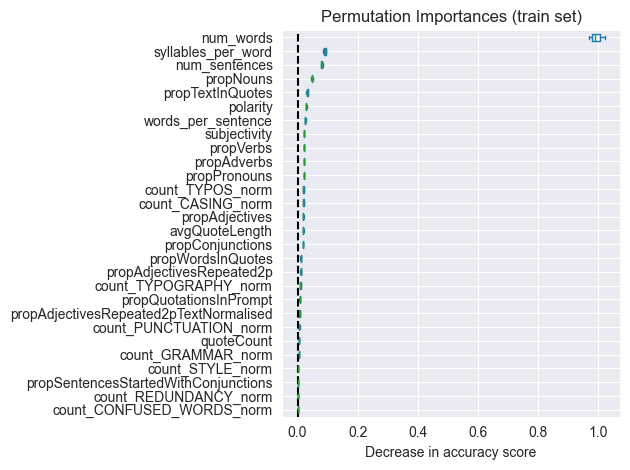

In [21]:
model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0))

results_df = cross_validate(model, X_train, y_train, n_folds=5, n_runs=5)
display(results_df)

model.fit(X_train, y_train)
result = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

2024-03-15 18:31:48,887 - INFO - Using 5x5 cross validation


  0%|          | 0/25 [00:00<?, ?it/s]

Metric        rmse                                 mae            \
Target     content   wording mean_columnwise   content   wording   
mean      0.601375  0.736119        0.668747  0.460722  0.571856   
stdev     0.010891  0.014061        0.012476  0.007573  0.011508   
n_trials        25        25               2        25        25   

Metric                          r2                            
Target   mean_columnwise   content   wording mean_columnwise  
mean            0.516289  0.666109  0.500101        0.583105  
stdev            0.00954  0.018761  0.016845        0.017803  
n_trials               2        25        25               2

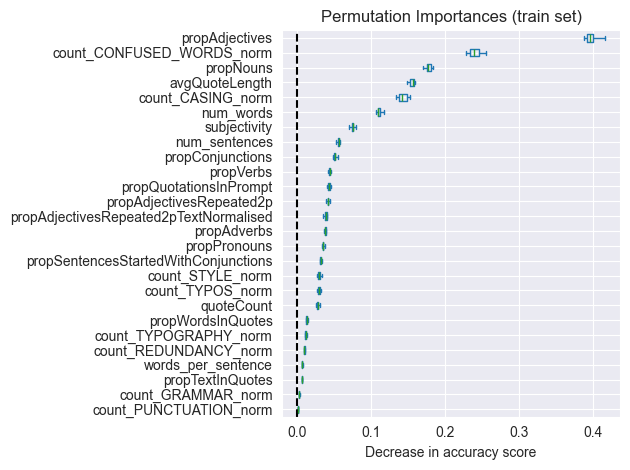

In [22]:
X_train_ss = X_train.drop(columns=["num_words", "num_sentences"])

model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0))

results_df = cross_validate(model, X_train_ss, y_train, n_folds=5, n_runs=5)
display(results_df)

model.fit(X_train_ss, y_train)
result = permutation_importance(
    model, X_train_ss, y_train, n_repeats=10, random_state=42, n_jobs=1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### Save feature_df to csv to avoid re-running the feature calculations again

In [34]:
summary_df.to_csv("../data/feature_df.csv", index=False)